In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

#### Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [4]:
series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")['Count']

In [5]:
series_st = series.copy()
series_st = boxcox(series_st, 0)
series_st = series_st[1:] - series_st[:-1]
series_st = series_st[12:] - series_st[:-12]

Собрал ряды. Подготавливаю функции


In [6]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [7]:
ser = moving_average(series, 7)

In [8]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

In [9]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [10]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [11]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i])/season_len
    return sum / season_len

In [12]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [13]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [14]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [15]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

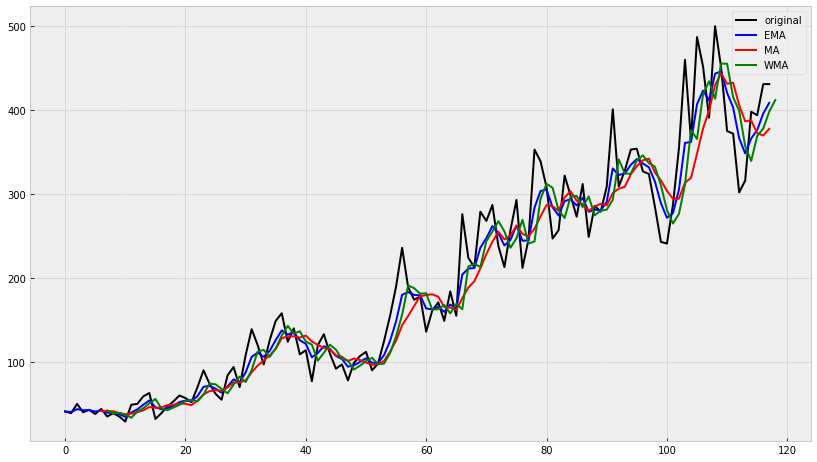

In [16]:
ema = exponential_moving_average(series, 0.36)
wma = weighted_moving_average(series, 7, [1,1,2,3,4,8,16])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='black',label='original')
    plt.plot(ema, color='blue', linewidth='2', label='EMA')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Начинаю применять методы обработки, и сразу хочу заметить на сколько оперативнее отрабатывает метод экспоненциального сглаживания - лаг.

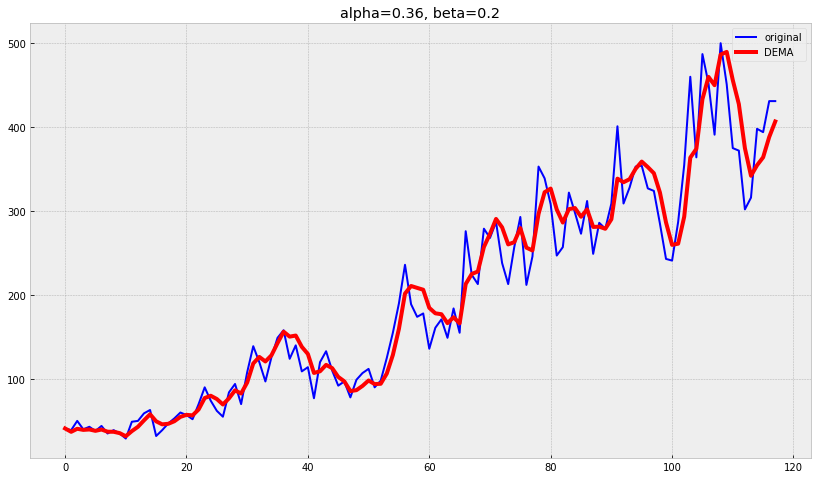

In [17]:
plot_dema(0.36, 0.2)

Двойное экспоненциальное сглаживание, кажется, очень хороший метод для нестационарного ряда с сильным влиянием тренда

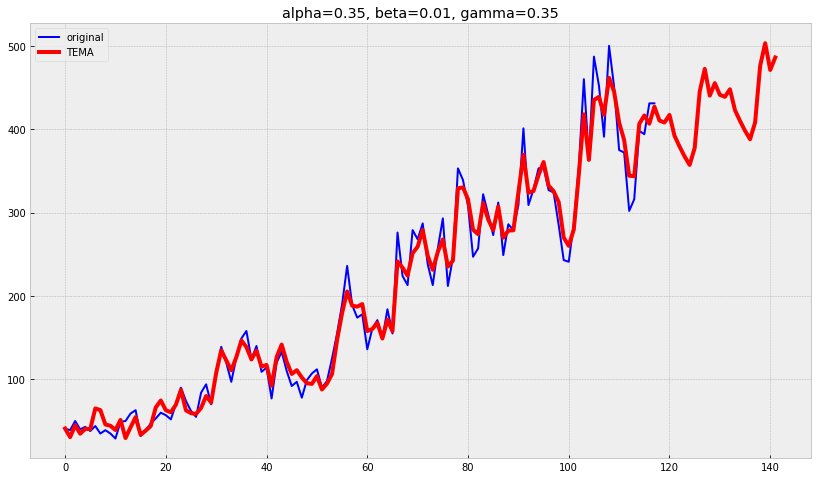

In [58]:
plot_tema(0.35, 0.01, 0.35)

А Хольт-Винтерс, из-за поправок сезонности не так хорош

In [19]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [20]:
train, test, val = series[:60], series[60:70], series[70:]

In [21]:
def mse(X):
    alpha, beta = X
    result = double_ema(series, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [22]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0.36, 1), (0, 1)))

In [23]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 43282.979447762424
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9912.15638351, 633369.17082779])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([0.36, 0.  ])


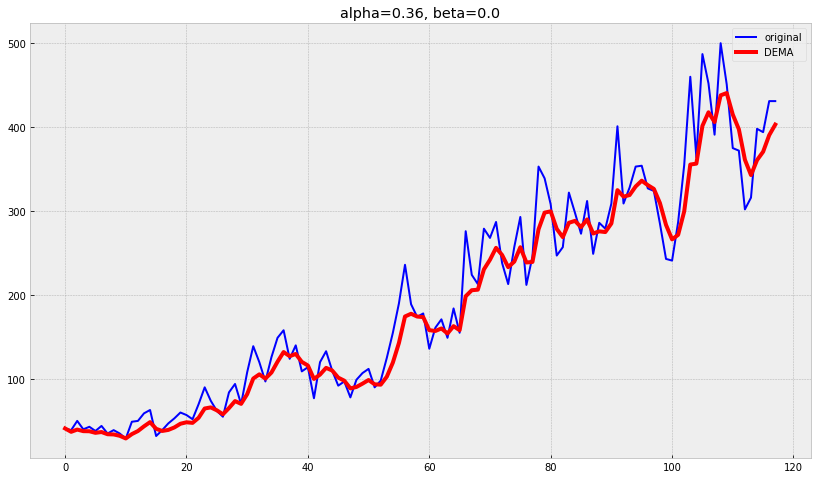

In [29]:
plot_dema(alpha_opt, beta_opt)

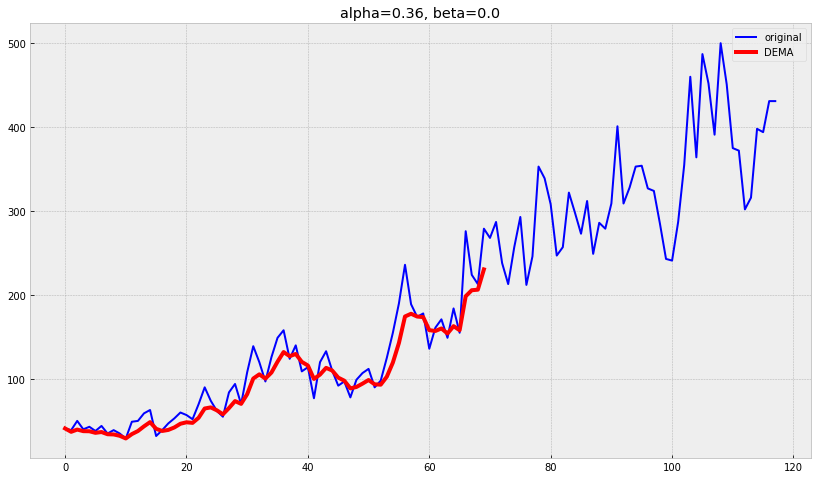

Теперь перейдем к стационарному ряду
  

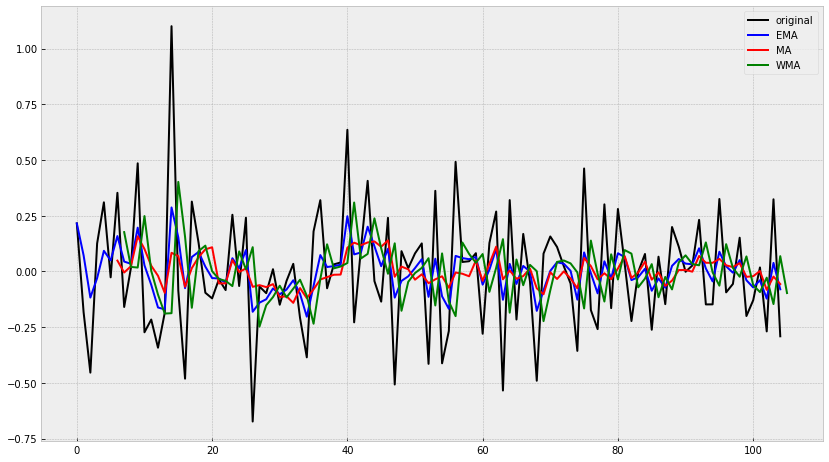

In [34]:
ema = exponential_moving_average(series_st, 0.36)
wma = weighted_moving_average(series_st, 7, [1,1,2,3,4,8,16])
ma = moving_average(series_st, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='black',label='original')
    plt.plot(ema, color='blue', linewidth='2', label='EMA')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

In [35]:
def plot_dema_st(alpha, beta):
    dema = double_ema(series_st, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series_st, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [36]:
def plot_tema_st(alpha, beta, gamma, ser=series_st, ser_to_plot=series_st, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

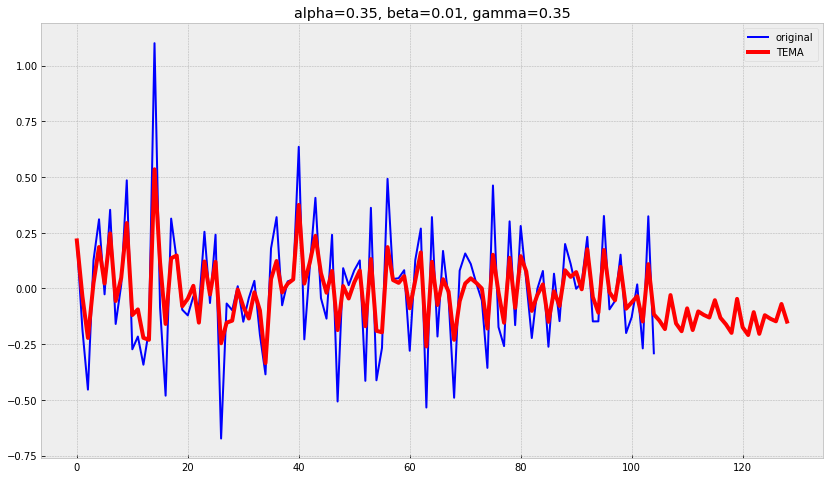

In [44]:
plot_tema_st(0.35,0.01,0.35) 

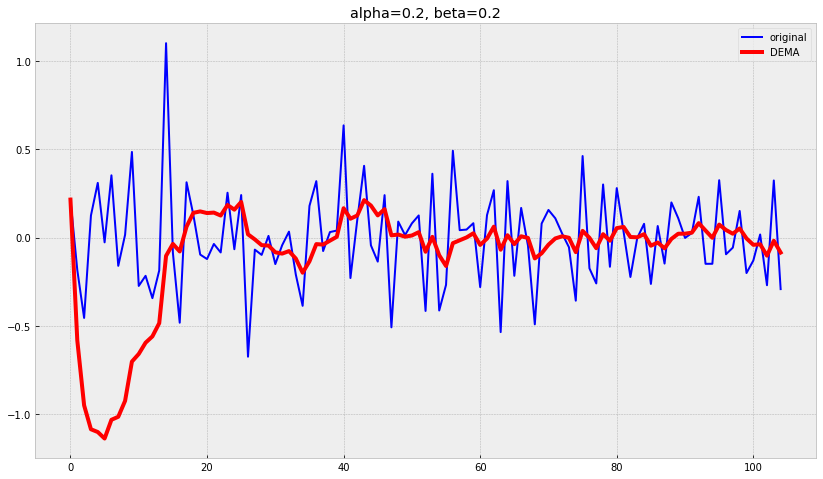

In [38]:
plot_dema_st(0.2,0.2)

In [46]:
train, test, val = series_st[:60], series_st[60:70], series_st[70:]

In [47]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [48]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [49]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.14298123723211056
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.51583215e-06,  7.84650123e-06, -7.56894547e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 40
      nit: 8
   status: 0
  success: True
        x: array([0.99891506, 0.00725337, 0.89165999])


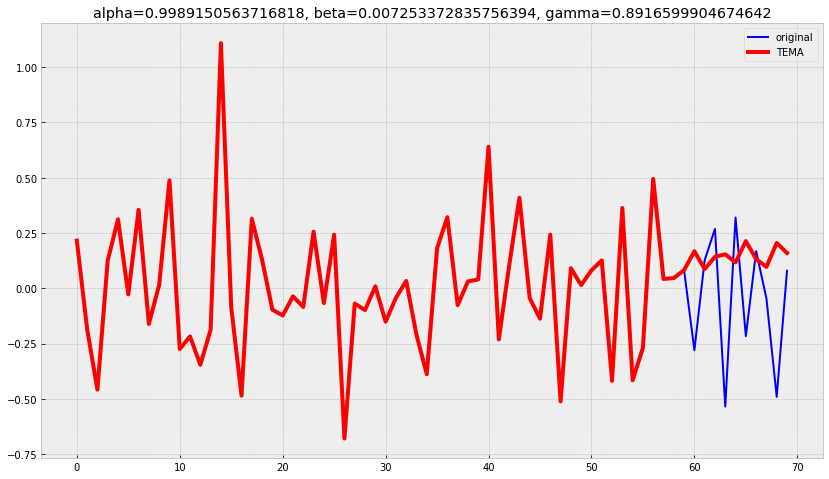

In [51]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_st[:70], n_preds=len(test))

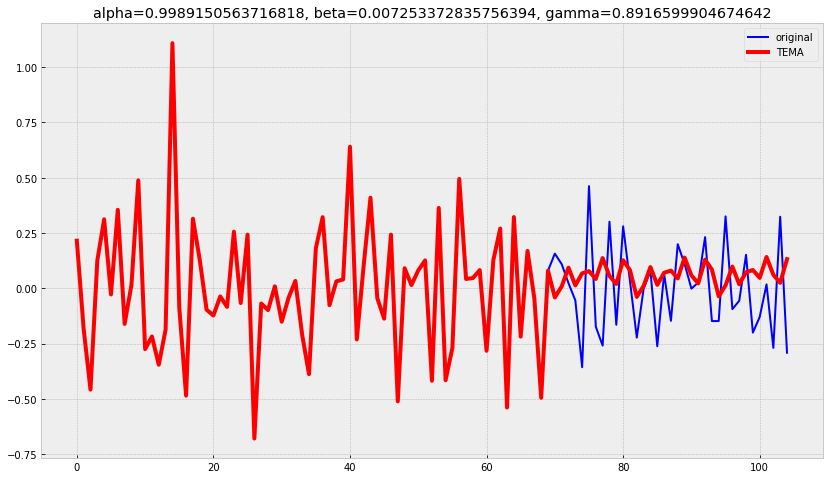

In [52]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series_st[:70], ser_to_plot=series_st, n_preds=len(val))

параметры метода выглядят избыточными

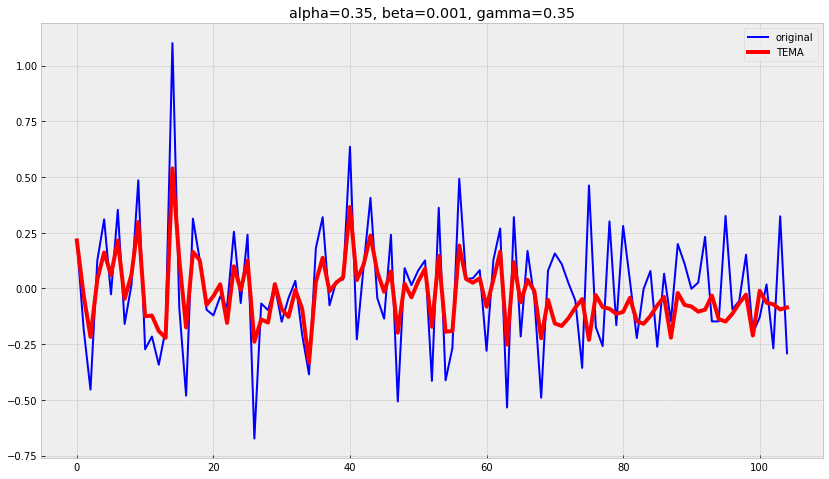

In [57]:
plot_tema(0.35,0.001,0.35, ser=series_st[:70], ser_to_plot=series_st, n_preds=len(val))